In [1]:
import sys
sys.path.append('/content/FreewayGame/leonardo/')
%matplotlib inline
from collections import defaultdict
from typing import List

import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

import gym

import src.agents as agents
import src.episode as episode
import src.environment as environment
import src.aux_plots as aux_plots
import src.serializer as serializer

In [2]:
def print_result(i, scores, total_reward, score):
    if i % 10 == 0:
        print(f"Run [{i:4}] - Total reward: {total_reward:7.2f} Mean scores: {sum(scores) / len(scores):.2f} Means Scores[:-10]: {sum(scores[-10:]) / len(scores[-10:]):5.2f} Score: {score:2} ")

In [3]:
RAM_mask = [
      14  # Chicken Y
    , 16  # Chicken Lane Collide
    , 108, 109, 110, 111, 112, 113, 114, 115, 116, 117  # Car X Coords
]

In [4]:
def reduce_state(ob):
    # Doesn't matter where we were hit
    ob[16] = 1 if ob[16] != 255 else 0

    # Reduce chicken y-position
    ob[14] = ob[14] // 3

    for b in range(108, 118):
        # The chicken is in the x-posistion ~49
        if ob[b] < 20 or ob[b] > 80:
            # We don't need to represent cars far from the chicken
            ob[b] = 0
        else:
            # Reduce the cars x-positions sample space
            ob[b] = ob[b] // 3

    return ob
    
def reward_policy(reward, ob, action):
    if reward == 1:
        reward = reward_policy.REWARD_IF_CROSS
    elif ob[16] == 1:  # Collision!
        reward = reward_policy.REWARD_IF_COLISION
    elif action != 1:  # Don't incentivate staying still
        reward = reward_policy.REWARD_IF_STILL

    return reward

def train(agent, env, name, n_runs=5000, n_render=500, n_print=10):
    scores = []
    total_rewards = []
    for i in range(n_runs):
        render = i % n_render == (n_render-1)

        E = defaultdict(lambda: np.zeros(2))

        game_over = False
        state = env.reset()
        state = reduce_state(state)[RAM_mask].data.tobytes()  # Select useful bytes
        action = agent.act(state)

        score = 0
        total_reward = 0

        while not game_over:
            if render:
                time.sleep(0.005)
                env.render()

            old_state = state
            old_action = action
            ob, reward, game_over, _ = env.step(action)

            ob = reduce_state(ob)
            reward = reward_policy(reward, ob, action)

            total_reward += reward

            if reward == reward_policy.REWARD_IF_CROSS:
                score += 1

            state = ob[RAM_mask].data.tobytes()

            action = agent.act(state)  # Next action

            E[old_state][old_action] += 1

            agent.update(old_s=old_state, new_s=state, old_a=old_action, new_a=action, reward=reward, E=i+1)

        scores.append(score)
        total_rewards.append(total_reward)
        
        if i%500 == 499:
        
            exp = serializer.Experiment(agent, scores, total_rewards, reduce_state, reward_policy)
            exp.save_experiment(name)

        if i % n_print == 0:
            print(f"Run [{i:4}] - Total reward: {total_reward:7.2f} Mean scores: {sum(scores) / len(scores):.2f} Means Scores[:-10]: {sum(scores[-10:]) / len(scores[-10:]):5.2f} Score: {score:2} ")
    return scores, total_rewards
    

    
    

In [5]:
def run_lfa_experiment(name, n_runs=2500, AVAILABLE_ACTIONS = 2, GAMMA = 0.99, N0 = 2.5, ALPHA = 0.001,
                        LAMB = 0.0001, REWARD_IF_CROSS=500, REWARD_IF_COLISION=-10, REWARD_IF_STILL=-1):

    env, initial_state = environment.get_env()
    
    reward_policy.REWARD_IF_CROSS = REWARD_IF_CROSS
    reward_policy.REWARD_IF_COLISION = REWARD_IF_COLISION
    reward_policy.REWARD_IF_STILL = REWARD_IF_STILL

    agent = agents.SarsaLFA(gamma=GAMMA, state_size=len(RAM_mask), available_actions=AVAILABLE_ACTIONS, N0=N0, alpha=ALPHA, lamb=LAMB)
    agent.trainScaler(env, RAM_mask)
    
    scores, total_rewards = train(agent, env, name, n_runs=n_runs, n_render=500, n_print=10)
    aux_plots.plot_scores(scores)
    aux_plots.plot_rewards(total_rewards)

Run [   0] - Total reward: 2841.00 Mean scores: 10.00 Means Scores[:-10]: 10.00 Score: 10 
Run [  10] - Total reward: 4094.00 Mean scores: 12.82 Means Scores[:-10]: 13.10 Score: 12 
Run [  20] - Total reward: 5393.00 Mean scores: 13.10 Means Scores[:-10]: 13.40 Score: 14 
Run [  30] - Total reward: 5844.00 Mean scores: 13.58 Means Scores[:-10]: 14.60 Score: 15 
Run [  40] - Total reward: 6920.00 Mean scores: 14.10 Means Scores[:-10]: 15.70 Score: 17 
Run [  50] - Total reward: 7153.00 Mean scores: 14.55 Means Scores[:-10]: 16.40 Score: 17 
Run [  60] - Total reward: 8103.00 Mean scores: 15.00 Means Scores[:-10]: 17.30 Score: 19 
Run [  70] - Total reward: 8631.00 Mean scores: 15.45 Means Scores[:-10]: 18.20 Score: 20 
Run [  80] - Total reward: 8167.00 Mean scores: 15.69 Means Scores[:-10]: 17.40 Score: 19 
Run [  90] - Total reward: 8066.00 Mean scores: 15.91 Means Scores[:-10]: 17.70 Score: 19 
Run [ 100] - Total reward: 6796.00 Mean scores: 16.19 Means Scores[:-10]: 18.70 Score: 16 

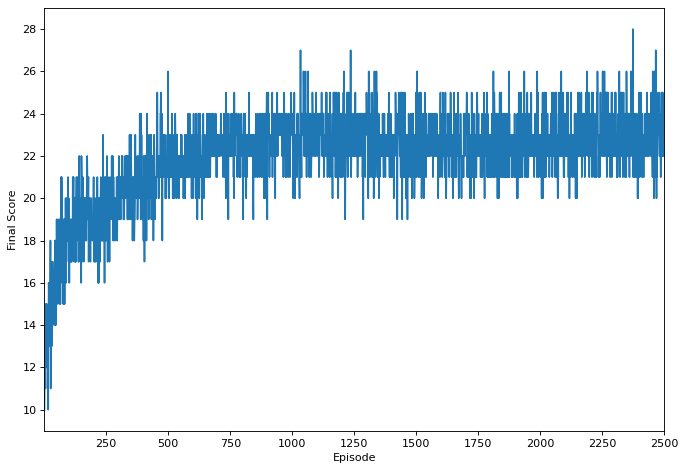

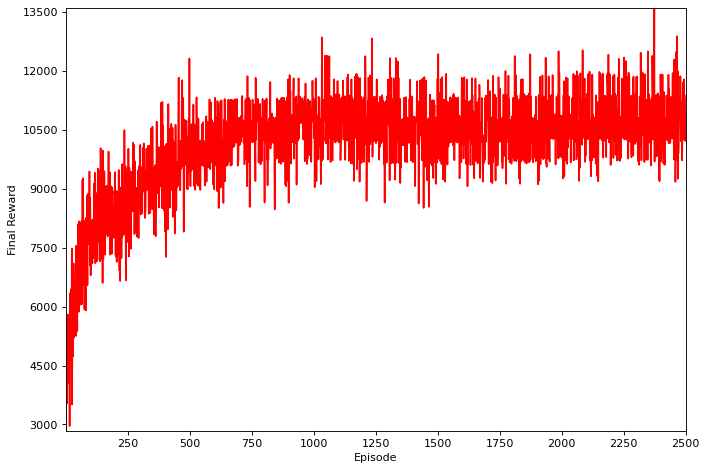

In [6]:
%%time
run_lfa_experiment('sarsa_lfa_n25', N0=2.5)